In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
road = stepmodel.read_zip(training_folder + r'model/{scen}/aon_pathfinder.zip'.format(scen=scenario))
distribution = stepmodel.read_zip(training_folder + r'model/{scen}/distribution.zip'.format(scen=scenario))
sm = road.copy()
sm.volumes = distribution.volumes

volumes: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 159.41it/s]


In [5]:
# each link can have its own capacity
sm.road_links['capacity'] = 2000

# 'volume_car' is used for road pathfinder
sm.volumes['volume_car'] = sm.volumes['car_owner']
sm.road_links
constrained = sm.copy()
free = sm.copy()

In [6]:
constrained.step_road_pathfinder(maxiters=5, log=True, speedup=True, tolerance=0.01)

step: 0  moved = 100.0 %
relgap = 0.0 %
step: 1  moved = 45.2 %
relgap = 23.3 %
step: 2  moved = 25.7 %
relgap = 3.5 %
step: 3  moved = 37.0 %
relgap = 1.2 %
step: 4  moved = 16.4 %
relgap = 1.5 %


In [11]:
constrained.car_los

,origin,destination,path,node_path,link_path,ntlegs,time,iteration,phi,iterations,weight,ntleg_time,link_eq_time,eq_time,link_actual_time,actual_time,link_free_time,free_time
0,zone_0,zone_0,[zone_0],[],[],[],0.000000,0,1.000000,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,zone_40,zone_37,"[zone_40, 340394504, 390306, 14950169, 2550387...","[340394504, 390306, 14950169, 255038747, 32206...","[172, 11932, 11434, 14785, 14953, 14950, 14450...","[(zone_40, 340394504), (24667525, zone_37)]",567.975795,0,1.000000,"(0, 1, 2, 3, 4)",1.000000,319.697310,251.439713,571.137023,252.164895,571.862205,248.278485,567.975795
2,zone_40,zone_106,"[zone_40, 340394504, 390306, 14950169, 2550387...","[340394504, 390306, 14950169, 255038747, 32206...","[172, 11932, 11434, 14785, 14953, 14950, 14450...","[(zone_40, 340394504), (60912644, zone_106)]",944.623170,0,1.000000,"(0, 1, 2, 3, 4)",1.000000,447.446828,500.367602,947.814430,501.077178,948.524005,497.176343,944.623170
3,zone_40,zone_107,"[zone_40, 340394504, 390306, 14950169, 2550387...","[340394504, 390306, 14950169, 255038747, 32206...","[172, 11932, 11434, 14785, 14953, 14950, 14450...","[(zone_40, 340394504), (2282290896, zone_107)]",944.996950,1,0.451891,"(1, 2, 3)",0.621176,269.506303,672.556193,942.062497,673.271732,942.778035,669.382205,938.888508
4,zone_40,zone_38,"[zone_40, 340394504, 390306, 14950169, 2550387...","[340394504, 390306, 14950169, 255038747, 32206...","[172, 11932, 11434, 14785, 14953, 14950, 14450...","[(zone_40, 340394504), (258360211, zone_38)]",899.619228,0,1.000000,"(0, 1, 2, 3, 4)",1.000000,372.969413,529.830933,902.800347,530.547332,903.516745,526.649814,899.619228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24786,zone_30,zone_28,"[zone_30, 560837929, 25034653, 34777850, 25034...","[560837929, 25034653, 34777850, 25034650, 5050...","[15302, 12376, 15301, 14709, 9118, 2242, 4521,...","[(zone_30, 560837929), (175012865, zone_28)]",880.665019,1,0.451891,"(1,)",0.176843,110.273084,743.182744,853.455828,764.073928,874.347012,687.835268,798.108351
24787,zone_30,zone_4,"[zone_30, 560837929, 25034653, 34777850, 25034...","[560837929, 25034653, 34777850, 25034650, 5050...","[15302, 12376, 15301, 14709, 9118, 2242, 4521,...","[(zone_30, 560837929), (94137863, zone_4)]",1393.663452,1,0.451891,"(1,)",0.176843,355.327718,1066.811148,1422.138867,1050.500264,1405.827982,963.256673,1318.584391
24788,zone_30,zone_100,"[zone_30, 560837929, 25034653, 34777850, 25034...","[560837929, 25034653, 34777850, 25034650, 5050...","[15302, 12376, 15301, 14709, 9118, 2242, 4521,...","[(zone_30, 560837929), (21732939, zone_100)]",824.256128,0,1.000000,"(0, 1, 2, 3, 4)",1.000000,237.526260,593.388088,830.914348,591.400131,828.926391,586.729868,824.256128
24789,zone_30,zone_101,"[zone_30, 560837929, 25034653, 34777850, 25034...","[560837929, 25034653, 34777850, 25034650, 5050...","[15302, 12376, 15301, 14709, 9118, 2242, 4521,...","[(zone_30, 560837929), (130052296, zone_101)]",1397.539426,2,0.256689,"(2, 4)",0.299469,451.293070,946.855256,1398.148326,944.880346,1396.173416,940.304249,1391.597319


In [13]:
free.step_road_pathfinder(maxiters=1, log=True, speedup=False, tolerance=0.001)

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.16it/s]


step: 0  moved = 100.0 %
relgap = 0.0 %


In [15]:
constrained.to_zip(training_folder + 'model/{scen}/constrained_road_pathfinder.zip'.format(scen=scenario))

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  8.39it/s]


# PLOT

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.97it/s]


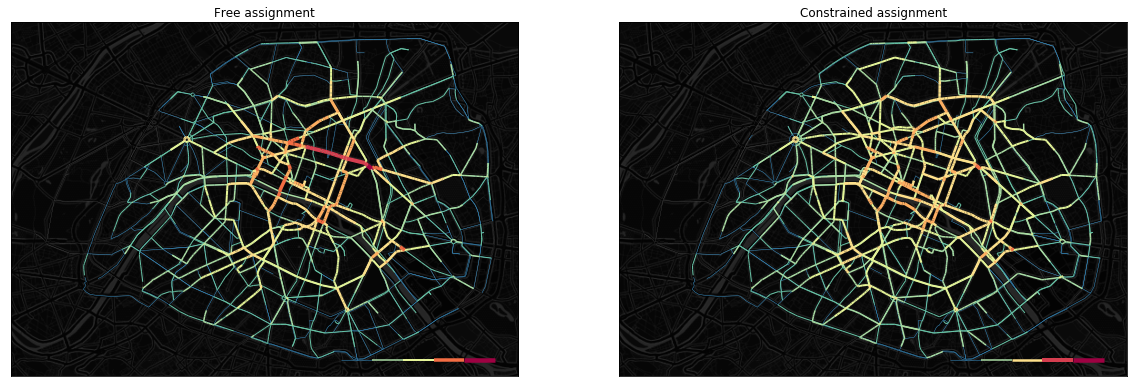

In [17]:
if manual:
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=[20, 20])

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    lv = [100, 1000, 2000, 5000, 7000]

    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/tileZ/tileX/tileY.png'
    plot = bandwidth(
        free.road_links.loc[free.road_links['flow'] > 0], value='flow',
        power=0.5, figsize=[25, 15], scale=0.5, legend_values=lv, 
        label_kwargs={'color':'white', 'fontsize':16}, ax=axes[0]
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Free assignment")

    plot = bandwidth(
        constrained.road_links.loc[constrained.road_links['flow'] > 0], value='flow',
        power=0.5, figsize=[25, 15], scale=0.5, legend_values=lv, 
        label_kwargs={'color':'white', 'fontsize':16}, ax=axes[1]
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Constrained assignment")
    fig.tigh_layout=True

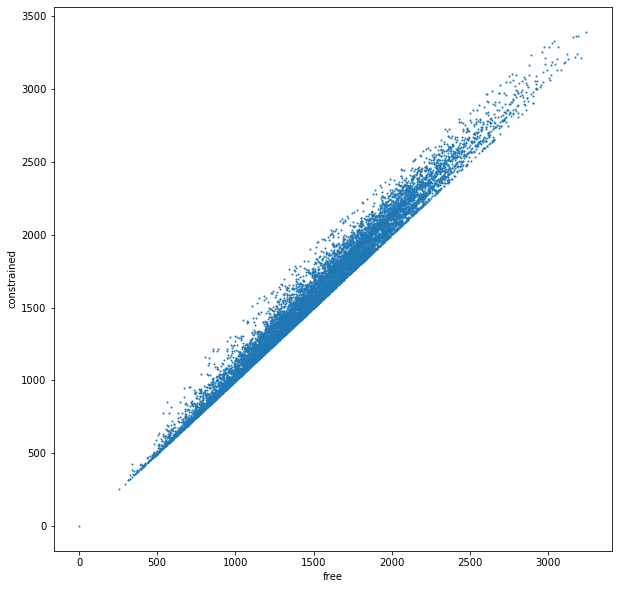

In [19]:
if manual:
    c = constrained.car_los.groupby(['origin', 'destination'])['actual_time'].min()
    f = free.car_los.groupby(['origin', 'destination'])['actual_time'].min()
    df = pd.DataFrame([c, f], index=['constrained', 'free']).T
    df.plot(kind='scatter', y='constrained', x='free', figsize=[10, 10], s=1)